In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import re
def floatize(day):
    ''' Helper func to convert strings of numbers and strings of 2- and 3- tuples into single floats'''
    if str(day)[0] != '(':
        return float(day)
    days = re.findall(r'[0-9]+', day)  ## convert """  '(20,24,25)'  """ into """  ['20', '24', '25']  """
    if len(days) == 3:
        return float(days[1])  # that's the best-guess day in the 3-tuples
    if len(days) == 2:
        return sum(float(d) for d in days) / 2
    return np.nan

#### Bring the data into the notebook

In [3]:
df = pd.read_csv('eventDF.csv', index_col=0)
df.head(3)

,Old_ID,ID,AgeSex,Day,Went_From,Went_To,Status,Got_From,Got_At,From_geo,To_geo
0,5,0.0,50F,6,Hefei,Wuhan,0.0,NaN,NaN,"(31.85, 117.28)","(30.58, 114.27)"
1,5,0.0,50F,"(6, 6, 7)",NaN,NaN,1.0,NaN,Wuhan,NaN,NaN
2,5,0.0,50F,7,Wuhan,Hefei,1.0,NaN,NaN,"(30.58, 114.27)","(31.85, 117.28)"


#### Filter out just the rows that show a sick traveler

In [4]:
sick_travels = df[(df.Status > 0) & (df.Status < 3) & (df.Went_From.notnull())]

In [5]:
sick_travels['Float_Day'] = sick_travels.Day.apply(floatize)

/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Use the float/int day columns calculated above to store a csv for mapping the sick travels

In [6]:
sick_travels.head(3)

,Old_ID,ID,AgeSex,Day,Went_From,Went_To,Status,Got_From,Got_At,From_geo,To_geo,Float_Day
2,5,0.0,50F,7,Wuhan,Hefei,1.0,NaN,NaN,"(30.58, 114.27)","(31.85, 117.28)",7.0
10,1,3.0,30M,17,Wuhan,Chaohu,1.0,NaN,NaN,"(30.58, 114.27)","(31.632, 117.882)",17.0
16,2,4.0,47M,10,Luzhou,Hefei,1.0,NaN,NaN,"(28.88, 105.38)","(31.85, 117.28)",10.0


In [7]:
sick_travels.Float_Day.values

array([ 7. , 17. , 10. , 10. , 21. , 22. , 17. , 19. , 19. , 17. , 11. ,
        4. , 16. , 14. , 17. , 15. , 17. ,  4. ,  4. ,  4. , 12. , 12. ,
       20. , 15. , 20. , 22. , 22. , 17. , 18. , 21. , 21. , 21. , 15. ,
       21. , 21. , 15. , 23. , 14. , 12. , 18. , 22. , 12. , 11. , 21. ,
       21. , 19. , 10. ,  9. ,  2. , 17. , 21. , 17. , 13. , 13. , 18. ,
       18. , 14. , 15. , 19. , 20. , 17. , 14. , 15. , 19. , 18. , 15. ,
       15. , 12. , 11. , 15. , 17. , 18. , 19. , 13. , 15. ,  6. , 13. ,
       10. , 17. , 23. , 20. , 19. , 15. , 16. , 15. ,  3. , 22. , 22. ,
       19. , 19. , 17. , 16. , 16. , 14. , 20. , 14. , 15. , 22. , 22. ,
       22. , 18. , 18. ,  6. ,  6. , 18. , 22. , 22. , 22. , 22. , 22. ,
       22. ,  9. , 19. , 22. , 20. ,  8. , 21. , 21. , 13. , 15. , 15. ,
       13. , 13. , 15.5, 15.5, 18. , 19. ,  6. , 18. , 20. , 19. , 19. ,
       22. , 20. , 22. , 22. , 20. , 20. , 16. , 18. ,  9. , 16. , 16. ,
       21. , 20. , 21. , 21.5, 23. , 16. , 19. , 20

Those are almost all integers except for a small proportion that are estimates, so just round down those few estimates and make something that will translate easily into day-length periods in a time delta.

In [9]:
sick_travels['Int_Day'] = [int(fl) for fl in sick_travels.Float_Day.values]
sick_travels.head(1)

/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Old_ID,ID,AgeSex,Day,Went_From,Went_To,Status,Got_From,Got_At,From_geo,To_geo,Float_Day,Int_Day
2,5,0.0,50F,7,Wuhan,Hefei,1.0,NaN,NaN,"(30.58, 114.27)","(31.85, 117.28)",7.0,7


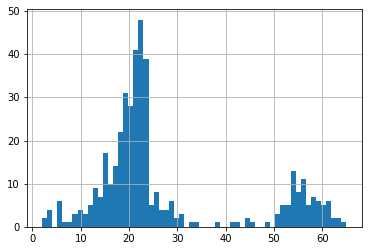

In [10]:
sick_travels.Float_Day.hist(bins=60);

Format a csv that is uploadable to Kepler.gl according to their specs at:
https://github.com/keplergl/kepler.gl/blob/master/docs/user-guides/b-kepler-gl-workflow/a-add-data-to-the-map.md

In [12]:
# kepler's csv parser looks for column headers that end with 'lat' and 'lng'
from_lat = [point[0] for point in sick_travels.From_geo.values]
from_lng = [point[1] for point in sick_travels.From_geo.values]
to_lat = [point[0] for point in sick_travels.To_geo.values]
to_lng = [point[1] for point in sick_travels.To_geo.values]

In [84]:
kepler_df = pd.DataFrame({'Old_ID':sick_travels.Old_ID,
                          'Status':sick_travels.Status, 
                          'Float_day':sick_travels.Float_Day,
                          'From_lat':from_lat,
                          'From_lng':from_lng,
                          'To_lat':to_lat,
                          'To_lng':to_lng})
kepler_df.head()

,Old_ID,Status,Float_day,From_lat,From_lng,To_lat,To_lng
2,5,1.0,7.0,30.580,114.270,31.850,117.280
10,1,1.0,17.0,30.580,114.270,31.632,117.882
16,2,1.0,10.0,28.880,105.380,31.850,117.280
22,3,1.0,10.0,29.808,121.561,31.850,117.280
27,10,2.0,21.0,30.580,114.270,31.850,117.280


So the tuples are string representations of tuples.  Need to convert to (lat, lng) float pairs.

In [22]:
def unstring(geo):
    ''' Helper func to convert strings of geo tuples into pairs of floats
    input: "(34.4, 100.0)" --> output: (34.4, 100.0)
    '''
    geo = re.findall(r'[\-0-9.]+', geo)
    
    return float(geo[0]), float(geo[1])

In [24]:
def string2floats(geo):
    '''alias unstring(geo)'''
    return unstring(geo)

In [15]:
from_lat = []
from_lng = []
to_lat = []
to_lng = []

for point in sick_travels.From_geo.values:
    lat, lng = unstring(point)
    from_lat.append(lat)
    from_lng.append(lng)
    
for point in sick_travels.To_geo.values:
    lat, lng = unstring(point)
    to_lat.append(lat)
    to_lng.append(lng)

In [275]:
sick_travels.Old_ID.values

array(['5', '1', '2', '3', '10', '461', '462', '14', '15', '26', '21',
       '22', '27', '25', '23', '56', '89', '99', '100', '101', '122',
       '144', '145', '146', '147', '150', '151', '162', '152', '153',
       '154', '155', '156', '163', '163', '166', '164', '165', '169',
       '173', '175', '176', '186', '192', '192', '193', '222', '231',
       '232', '241', '242', '252', '253', '253', '255', '255', '254',
       '254', '258', '259', '260', '261', '262', '264', '265', '266',
       '267', '280', '281', '300', '301', '307', '307', '308', '308',
       '302', '303', '304', '305', '313', '316', '317', '318', '319',
       '320', '343', '465', '463', '466', '469', '476', '477', '477',
       '601', '603', '625', '645', '645', '645', '645', '647', '646',
       '649', '649', '650', '651', '651', '652', '652', '653', '653',
       '654', '658', '659', '660', '665', '661', '667', '668', '669',
       '669', '670', '670', '670', '671', '676', '676', '673', '674',
       '675', '679'

### I'd like to have a clickable source in the hover tooltip for each patient in the map.  
#### I left some of the sources behind when I made the original spreadsheet in Numbers, but I left the original ID ('Old_ID' ) column for each row.  Where I made new rows (of patients not in the original data) I either added ID's like "133.5", for a patient who was found in the same source as Old_ID 133.0 but not in the data, or completely new ID's for newly discovered patients of interest.  For these I started at 999999.0 and counted down.  Here, I'll make all Old_ID's floats and make a map from the made-up indices to the unlisted sources.

A lot of those Old_ID's above don't link to a source, so will need to patch that up:

First get the original spreadsheet data.

In [163]:
original = pd.read_csv('../../COVID19_open_line_list.csv')
original.head()

,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44
0,1.0,30,male,"Chaohu City, Hefei City",Anhui,China,1.0,31.646960,117.716600,admin3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,47,male,"Baohe District, Hefei City",Anhui,China,1.0,31.778630,117.331900,admin3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,49,male,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,47,female,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,50,female,"Feidong County, Hefei City",Anhui,China,1.0,32.001230,117.568100,admin3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
# map all provided sources to their ID's
orig2source = {tup[0]:tup[1] for tup in zip(original.ID, original.source)}

In [295]:
oldids = set()
not_ids = set()
for i in sick_travels.Old_ID:
    try:
        oldids.add(float(i))
    except ValueError:
        not_ids.add(i)

In [296]:
# see how many ID's aren't in that original spreadsheet
in_orig = {idx for idx in oldids if idx in orig2source}
not_in_orig = {idx for idx in oldids if float(idx) not in orig2source}
print(len(in_orig), len(not_in_orig), len(not_ids))

261 44 8


So 261 of the 313 different travelers have the source included in the original spreadsheet,
44 are floats that aren't in the original, and 8 are non_floats (string URLs).  
I can create numeric ID's for the URLs, but what about those 44?

In [297]:
not_in_orig

{13455.5,
 13655.0,
 13658.0,
 13658.1,
 13671.0,
 13673.0,
 13723.0,
 13727.0,
 13743.0,
 13855.0,
 14823.0,
 14833.0,
 14881.0,
 14907.0,
 14911.0,
 14912.0,
 14913.0,
 14948.0,
 15040.0,
 15061.0,
 15064.0,
 15065.0,
 15197.0,
 15250.0,
 15255.0,
 15270.0,
 15282.0,
 15283.0,
 15354.0,
 17905.0,
 17906.0,
 17907.0,
 17912.0,
 17947.0,
 17962.0,
 17965.0,
 17967.0,
 17994.0,
 18015.0,
 18025.0,
 18058.0,
 18694.0,
 111111.0,
 999999.0}

The ones with decimals were ones I added into the spreadsheet that were connected to the accompanying int ID (13658.1 was connected to 13658.0 but wasn't in the original spreadsheet, e.g.).

In [301]:
updated = pd.read_csv('https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.csv',
                     low_memory=False) # low_memory keyword arg suppresses the warning

In [302]:
updated.shape

(266874, 33)

In [303]:
travelers = updated[updated.travel_history_dates.notnull()]
travelers.shape

(2124, 33)

In [310]:
travelers.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,30,male,"Chaohu City, Hefei City",Anhui,China,31.64696,117.7166,admin3,18.01.2020,...,NaN,NaN,NaN,Chaohu City,Hefei City,Anhui,China,340181.0,NaN,NaN
2,000-1-10,30,male,Hefei City,Anhui,China,31.79444,117.3428,admin2,17.01.2020,...,NaN,NaN,NaN,NaN,Hefei City,Anhui,China,340100.0,NaN,NaN
5,000-1-100,65,female,Shenzhen City,Guangdong,China,22.65389,114.1291,admin2,03.01.2020,...,NaN,NaN,NaN,NaN,Shenzhen City,Guangdong,China,440300.0,NaN,NaN
102,000-1-1008,30,female,Sanya City,Hainan,China,18.39084,109.4197,admin2,NaN,...,NaN,NaN,NaN,NaN,Sanya City,Hainan,China,460200.0,NaN,NaN
115,000-1-1009,26,female,Sanya City,Hainan,China,18.39084,109.4197,admin2,NaN,...,NaN,NaN,NaN,NaN,Sanya City,Hainan,China,460200.0,NaN,NaN


In [312]:
str_not_orig = {'000-1-' + str(int(idx)) for idx in not_in_orig}
len(str_not_orig)

43

In [314]:
not_orig = [idx in str_not_orig for idx in travelers.ID]
found = travelers[not_orig]
found

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
4198,000-1-13455,39,female,Siauliai,NaN,Lithuania,55.933330,23.316670,point,NaN,...,NaN,NaN,Siauliai,NaN,NaN,Siauliai,Lithuania,6.0,NaN,NaN
4199,000-1-13455,52,female,East Coast Demerara,NaN,Guyana,6.750018,-58.077146,admin3,NaN,...,11.03.2020,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4434,000-1-13655,40-49,male,Reykjavik,NaN,Iceland,64.133330,-21.933300,point,NaN,...,NaN,NaN,Reykjavik,NaN,NaN,Hofudborgarsvaedi,Iceland,3.0,NaN,NaN
4437,000-1-13658,35,male,Mexico City,NaN,Mexico,19.433330,-99.133300,point,NaN,...,NaN,NaN,Mexico City,NaN,NaN,Distrito Federal,Mexico,9.0,NaN,NaN
4454,000-1-13671,60-69,male,Toronto,Ontario,Canada,43.725290,-79.387000,admin2,NaN,...,NaN,NaN,NaN,NaN,Toronto,Ontario,Canada,169.0,NaN,NaN
4456,000-1-13673,29,male,Moscow,Moscow City,Russia,55.754000,37.623000,point,NaN,...,NaN,NaN,Moscow,NaN,NaN,Moscow City,Russia,43.0,NaN,NaN
4496,000-1-13723,39,female,New York City,New York,United States,40.661000,-73.944000,point,NaN,...,NaN,NaN,NaN,NaN,NaN,New York,United States,33.0,NaN,NaN
4500,000-1-13727,NaN,male,NaN,Tasmania,Australia,-41.998200,146.635900,admin1,NaN,...,NaN,NaN,NaN,NaN,NaN,Tasmania,Australia,9.0,NaN,NaN
4520,000-1-13743,40,male,NaN,NaN,Tunisia,34.161680,9.577214,admin0,29.02.2020,...,NaN,NaN,NaN,NaN,NaN,NaN,Tunisia,234.0,NaN,NaN
4653,000-1-13855,43,male,Puerto Madero,Buenos Aires,Argentina,-34.611900,-58.364700,point,NaN,...,NaN,NaN,Puerto Madero,NaN,NaN,Buenos Aires,Argentina,5.0,NaN,NaN


In [315]:
found_map = {idx:src for (idx, src) in zip([float(i[-5:]) for i in found.ID], found.source)}

In [316]:
sum(found.source.isnull())

0

Now those 42 can be added to the orig2source dict

In [317]:
orig2source.update(found_map)

Also get those 2 decimal ones in there

In [320]:
orig2source[13658.1] = orig2source[13658]
orig2source[13455.5] = orig2source[13455]

Now the 2 invented indices, 111111 and 999999

In [321]:
orig2source[999999] = 'https://www.nytimes.com/2020/02/04/health/coronavirus-symptoms-germany.html'
orig2source[111111] = 'https://www.thestar.com.my/news/nation/2020/01/30/coronavirus-25-people-test-negative-in-sabah-says-state-health-dept'

And then make new ID's for the 8 with URL id's

In [323]:
next_int = 999998
sources = []
ids = []
for id in kepler_df.Old_ID.values:
    try:
        if float(id) in orig2source:
            sources.append(orig2source[float(id)].split())
            ids.append(float(id))
    except ValueError:
        sources.append([id])  # I used the source for ID's where the patient was new to the data table
        ids.append(float(next_int))
        next_int -= 1  # just counting down from 999999, for whatever reason
    except AttributeError:
        ids.append(float(id))
        sources.append([])
    except:
        print('some ' + str(id))

In [324]:
print(len(sources), len(ids))
sources

415 415


[['http://ah.people.com.cn/GB/n2/2020/0127/c358266-33746566.html'],
 ['http://ah.people.com.cn/GB/n2/2020/0127/c358266-33746566.html'],
 ['http://ah.people.com.cn/GB/n2/2020/0127/c358266-33746566.html'],
 ['http://ah.people.com.cn/GB/n2/2020/0127/c358266-33746566.html'],
 ['http://ah.people.com.cn/GB/n2/2020/0127/c358266-33746566.html'],
 ['http://ah.people.com.cn/GB/n2/2020/0127/c358266-33746566.html'],
 ['http://ah.people.com.cn/GB/n2/2020/0127/c358266-33746566.html'],
 ['http://www.chizhou.gov.cn/OpennessContent/show/839042.html'],
 ['http://wjw.bengbu.gov.cn/gzdt/article.jsp?articleId=3449287594'],
 ['http://news.xmnn.cn/xmnn/2020/01/22/100656796.shtml'],
 ['http://news.xmnn.cn/xmnn/2020/01/22/100656796.shtml'],
 ['http://news.xmnn.cn/xmnn/2020/01/22/100656796.shtml'],
 ['http://news.xmnn.cn/xmnn/2020/01/22/100656796.shtml'],
 [],
 ['http://news.xmnn.cn/xmnn/2020/01/22/100656796.shtml'],
 ['(1)',
  'https://baijiahao.baidu.com/s?id=1657052519295481709&wfr=spider&for=pc;',
  '(2)',


Get rid of the non-URL sources

In [325]:
sources = [[url for url in urllist if url.startswith('http')] for urllist in sources]

In [326]:
len(sources)

415

In [327]:
len(ids) == len(sources)

True

In [328]:
kepler_df = pd.DataFrame({'Old_ID':ids,
                          'Status':sick_travels.Status,  # for color-coding any map paths
                          'Float_day':sick_travels.Float_Day,  # probably not used in kepler, but...
                          'From_lat':from_lat,
                          'From_lng':from_lng,
                          'To_lat':to_lat,
                          'To_lng':to_lng,
                          'From':sick_travels.Went_From,
                          'To':sick_travels.Went_To,
                          'Had_Symptoms':['Yes' if status == 2.0 else 'Not yet'
                                          for status in sick_travels.Status.values],
                          'Story':sources})
kepler_df.head()

,Old_ID,Status,Float_day,From_lat,From_lng,To_lat,To_lng,From,To,Had_Symptoms,Story
2,5.0,1.0,7.0,30.580,114.270,31.850,117.280,Wuhan,Hefei,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...
10,1.0,1.0,17.0,30.580,114.270,31.632,117.882,Wuhan,Chaohu,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...
16,2.0,1.0,10.0,28.880,105.380,31.850,117.280,Luzhou,Hefei,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...
22,3.0,1.0,10.0,29.808,121.561,31.850,117.280,Yinzhou,Hefei,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...
27,10.0,2.0,21.0,30.580,114.270,31.850,117.280,Wuhan,Hefei,Yes,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...


In [329]:
kepler_df.To_lng.min()  # just making sure it picked up the negatives

-157.846

In [330]:
zeroday = pd.to_datetime('2019-12-31')
dates = [zeroday + pd.Timedelta('1D') * day for day in kepler_df.Float_day]
kepler_df['Date'] = dates
# string version for the tooltip when hovering over a sick travel in kepler map
kepler_df['String_Date'] = [str(d)[:10] for d in dates]

In [331]:
unix_secs = [(date - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s') for date in kepler_df.Date]
kepler_df['Unix'] = unix_secs
kepler_df.head()

,Old_ID,Status,Float_day,From_lat,From_lng,To_lat,To_lng,From,To,Had_Symptoms,Story,Date,String_Date,Unix
2,5.0,1.0,7.0,30.580,114.270,31.850,117.280,Wuhan,Hefei,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-07,2020-01-07,1578355200
10,1.0,1.0,17.0,30.580,114.270,31.632,117.882,Wuhan,Chaohu,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-17,2020-01-17,1579219200
16,2.0,1.0,10.0,28.880,105.380,31.850,117.280,Luzhou,Hefei,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-10,2020-01-10,1578614400
22,3.0,1.0,10.0,29.808,121.561,31.850,117.280,Yinzhou,Hefei,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-10,2020-01-10,1578614400
27,10.0,2.0,21.0,30.580,114.270,31.850,117.280,Wuhan,Hefei,Yes,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-21,2020-01-21,1579564800


In [332]:
kepler_df.head()

,Old_ID,Status,Float_day,From_lat,From_lng,To_lat,To_lng,From,To,Had_Symptoms,Story,Date,String_Date,Unix
2,5.0,1.0,7.0,30.580,114.270,31.850,117.280,Wuhan,Hefei,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-07,2020-01-07,1578355200
10,1.0,1.0,17.0,30.580,114.270,31.632,117.882,Wuhan,Chaohu,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-17,2020-01-17,1579219200
16,2.0,1.0,10.0,28.880,105.380,31.850,117.280,Luzhou,Hefei,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-10,2020-01-10,1578614400
22,3.0,1.0,10.0,29.808,121.561,31.850,117.280,Yinzhou,Hefei,Not yet,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-10,2020-01-10,1578614400
27,10.0,2.0,21.0,30.580,114.270,31.850,117.280,Wuhan,Hefei,Yes,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...,2020-01-21,2020-01-21,1579564800


Kepler actually wants urls, not lists of urls, in order to be clickable, so just use the first url from each list

In [337]:
kepler_df['Sources'] = kepler_df.Story.copy()
kepler_df['Story'] = [s[0] if s else '' for s in kepler_df.Story]

In [338]:
kepler_df.head()

,Old_ID,Status,Float_day,From_lat,From_lng,To_lat,To_lng,From,To,Had_Symptoms,Story,Date,String_Date,Unix,Sources
2,5.0,1.0,7.0,30.580,114.270,31.850,117.280,Wuhan,Hefei,Not yet,http://ah.people.com.cn/GB/n2/2020/0127/c35826...,2020-01-07,2020-01-07,1578355200,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...
10,1.0,1.0,17.0,30.580,114.270,31.632,117.882,Wuhan,Chaohu,Not yet,http://ah.people.com.cn/GB/n2/2020/0127/c35826...,2020-01-17,2020-01-17,1579219200,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...
16,2.0,1.0,10.0,28.880,105.380,31.850,117.280,Luzhou,Hefei,Not yet,http://ah.people.com.cn/GB/n2/2020/0127/c35826...,2020-01-10,2020-01-10,1578614400,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...
22,3.0,1.0,10.0,29.808,121.561,31.850,117.280,Yinzhou,Hefei,Not yet,http://ah.people.com.cn/GB/n2/2020/0127/c35826...,2020-01-10,2020-01-10,1578614400,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...
27,10.0,2.0,21.0,30.580,114.270,31.850,117.280,Wuhan,Hefei,Yes,http://ah.people.com.cn/GB/n2/2020/0127/c35826...,2020-01-21,2020-01-21,1579564800,[http://ah.people.com.cn/GB/n2/2020/0127/c3582...


In [339]:
kepler_df.to_csv('kepler_df.csv')

### ========= For adding GeoJSON layers ===========
#### It didn't work well for this map, because there's no mechanism available to line up the playback animation of this layer on top of the playback for a filter on the other data's dates

In [19]:
# In order to animate the travel paths in kepler, you need to use GeoJSON
import geojson

In [55]:
import keplergl  # this embeds a widget that allows you to work with kepler directly here, but I can't open the view

In [56]:
map_1 = keplergl.KeplerGl(height=500)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [63]:
map_1.add_data(data=kepler_df.head(10), name='data1')

In [70]:
type(map_1)

keplergl.keplergl.KeplerGl

In [96]:
kepler_df.head()

,Old_ID,Status,Float_day,From_lat,From_lng,To_lat,To_lng,Date,Unix
2,5,1.0,7.0,30.580,114.270,31.850,117.280,2020-01-07,1578355200
10,1,1.0,17.0,30.580,114.270,31.632,117.882,2020-01-17,1579219200
16,2,1.0,10.0,28.880,105.380,31.850,117.280,2020-01-10,1578614400
22,3,1.0,10.0,29.808,121.561,31.850,117.280,2020-01-10,1578614400
27,10,2.0,21.0,30.580,114.270,31.850,117.280,2020-01-21,1579564800


In [136]:
## The part of this function that splits a segment into subsegments ends up being needless, because the start and
#### end points are enough for kepler to "animate" the segment.  

def animate_paths(df, n_segs, n_hrs):
    '''
    Convert the travel represented by each row of the df into 
    a series of subsegments, so that kepler can animate its geojson.
    Input n_segs determines the sumber of subsegments.
    Input n_hrs determines how long the path traces.
    Return:  A bunch of GeoJSON LineString Geometries
    '''
    feats = []
    for i in range(len(df)):
        row = df.iloc[i]
        lats = np.linspace(row.From_lat, row.To_lat, n_segs + 1)
        lons = np.linspace(row.From_lng, row.To_lng, n_segs + 1)
        times = np.linspace(row.Unix, row.Unix + (60*60*n_hrs), n_segs + 1)
        props = {"date": str(row.Date)[:10], 
                 "status": "symptomatic" if row.Status == 2.0 else "not symptomatic"}
        geom = geojson.LineString(coordinates=list(zip(lons, lats, np.zeros(n_segs+1), times)))
        feat = geojson.Feature(geometry=geom, properties=props)
        feats.append(feat)
        
    return geojson.FeatureCollection(feats)

In [143]:
mapfeats = animate_paths(kepler_df, n_segs=2, n_hrs = 20)

In [144]:
with open('kep_df.geojson', 'w') as f:
    geojson.dump(mapfeats, f)

In [145]:
len(mapfeats['features'])

415

In [27]:
with open('kep_df.geojson', 'r') as f:
    mapfeats = geojson.load(f)

In [33]:
'''
In order to animate the path, the geoJSON data needs to contain `LineString` in its feature geometry,
and the coordinates in the LineString need to have 4 elements in the formats of
[longitude, latitude, altitude, timestamp] with the last element being a timestamp.
Valid timestamp formats include unix in seconds such as `1564184363` or in milliseconds such as `1564184363000`.


geoJSON style keywords
(keyword argument of geojson.FeatureCollection.Feature(geometry, properties))
"properties": {
  "lineColor": [130, 154, 227],
  "lineWidth": 0.5,
  "fillColor": [255, 0, 0],
  "radius": 1 // Point
}
'''

'\ngeoJSON style keywords\n(keyword argument of geojson.FeatureCollection.Feature(geometry, properties))\n"properties": {\n  "lineColor": [130, 154, 227],\n  "lineWidth": 0.5,\n  "fillColor": [255, 0, 0],\n  "radius": 1 // Point\n}\n'

In [31]:
df['date'] = pd.to_datetime(df.date)

In [35]:
jan1 = pd.Timestamp("2020-01-01 12:00:00")

In [36]:
jan1

Timestamp('2020-01-01 12:00:00')